In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ECON30076 Industrial Economics 
Week 5 - Merger Evaluation
Code for the coding exercise

This code 
1. simulates market share data given some parameters, 
2. estimates the demand parameters in a Logit model, 
3. estimates marginal costs based on Bertrand-Nash competition,
4. simulates a merger.

Created by Kevin Tran

Outline of the code:
0. Settings for the code
1. Simulate choice data
2. Estimate Logit model to recover demand parameters and marginal costs
3. Simulate merger
"""

### First, import the required packages
# Pandas to work with DataFrames
import pandas as pd
# suppress scientific notation
pd.options.display.float_format = '{:.3f}'.format
# Numpy for random draws and other operators
import numpy as np
# Adjust display of arrays
import sys
np.set_printoptions(threshold=sys.maxsize)
# scipy for numerical solver
from scipy.optimize import fsolve
# statsmodels for OLS
import statsmodels.api as sm
# To create block-diagonal matrices
from scipy.linalg import block_diag
# For plotting
import matplotlib.pyplot as plt

In [3]:
#%% 0. Settings

# We assume consumers choose one out of three products, or do not buy at all. 
# Consumers only care about the price, another product characteristic, 
# and product fixed effects.

# Consumers choose according to indirect utility

# u = beta_p * price + beta_x * X + FE + epsilon

# where epsilon follows an Extreme value type I distribution.

# For the simulation, we need to set values for beta_p and beta_cores
# and draw fixed effects (FE) for every market-product combination.
# Since we want to simulate market shares, we do not need to draw the error
# terms. Instead, we assume that the Logit choice probabilities represent
# market shares.

### Set values for the utility coefficients
beta_p = -1
beta_x = 5

### Setting a seed allows you to reproduce results involving random numbers
# remove this to obtain different results every time you run it
np.random.seed(1234)

#%% 1. Simulate market data

### Steps:
# 1. Create empty data set for 50 markets choosing from 3 goods + outside good
    # you can change these numbers if you like
n_market = 50
n_prods = 3
# 2. Create exogenous observable data (X), unobservable marginal costs (mc), 
    # and unobservable fixed effects (FE) 
    # for each observation
# 3. Calculate optimal prices given Bertrand-Nash competition
# 4. Calculate market shares for each observation

###### 1.1 Create basic data set structure

### We need two identifiers: one for the products, one for the markets
# 50 markets with three products

# Create a vector of market identifiers
id_market = [x for x in range(n_market)]

## Loop through products and create a DataFrame with these market IDs and 
# the respective product ID. Add everything into a list
# Always add one row for the outside good
# Empty list to save in
dflist = []
for i in range(n_prods+1):
    df_sub = pd.DataFrame(id_market, columns = ['market_id'])
    # Add column with product ID
    df_sub['product_id'] = i
    # Add to list
    dflist.append(df_sub)
    
## Combine dflist to one DataFrame
df = pd.concat(dflist)
# Sort by market_id first
df.sort_values(['market_id', 'product_id'], inplace = True)
# Reset index
df.reset_index(drop = True, inplace = True)


###### 1.2 Create product characteristics
# Draw Xs, marginal costs, and product-market fixed effects 
# from uniform distribution between 0 and 1
df['mc'] = np.random.uniform(size = len(df))
df['X'] = np.random.uniform(size = len(df))
# For FEs, center these around 0
df['FEs'] = np.random.uniform(size = len(df)) - 0.5
# Replace these by 0 for the outside good
df.loc[df['product_id'] == 0, ['mc', 'X', 'FEs']] = 0
df

,market_id,product_id,mc,X,FEs
0,0,0,0.000,0.000,0.000
1,0,1,0.622,0.881,0.224
2,0,2,0.438,0.628,-0.481
3,0,3,0.785,0.930,-0.214
4,1,0,0.000,0.000,0.000
...,...,...,...,...,...
195,48,3,0.370,0.846,-0.148
196,49,0,0.000,0.000,0.000
197,49,1,0.103,0.903,0.079
198,49,2,0.802,0.226,0.118


In [4]:
###### 1.3 Calculate optimal Bertrand-Nash prices
### In order to use scipy.optimize.fsolve, we need to define a function that
# takes a vector of values (i.e. suggested prices) and returns a vector
# of equal dimension. fsolve tries to find a vector for which the function
# returns a vector of zeros.
## Define this function for all markets jointly (could also loop over markets,
# but it is generally preferable to avoid loops where possible)
def foc(p, df_fun):
    ### Inside the function, we use a vector p of prices to calculate the values
    # that the derivatives of the profit functions take given these prices.
    # The goal is to find a vector p, where the derivates are zero, i.e.
    # the FOCs are fulfilled.
    
    ### First assign these prices to column p (not for the outside good)
    df_fun['price'] = 0.0   
    df_fun.loc[df_fun['product_id'] != 0, ['price']] = p
    
    ### Create D matrix of derivatives of market shares w.r.t. own price
    ## First, calculate market shares given these prices
    # mean utility (denoted as delta in the slides)
    df_fun['delta'] = beta_p * df_fun['price'] + beta_x * df_fun['X'] + df_fun['FEs']
    # Calculate exp(delta)
    df_fun['exp_d'] = np.exp(df_fun['delta'])
    # Calculate sum of exps of delta for each market
    df_cons = df_fun[['market_id', 'exp_d']].groupby('market_id').agg('sum') \
        .reset_index().rename(columns = {'exp_d': 'sum_exp'})
    df_fun = df_fun.merge(df_cons, on = 'market_id', how = 'left', validate = 'm:1')
    # Calculate market shares
    df_fun['shares'] = df_fun['exp_d'] / df_fun['sum_exp']
    # Take only inside good market shares
    shares = df_fun.loc[df_fun['product_id'] != 0, 'shares'].values 
    # Calculate partial derivatives
    ds = beta_p * shares * (1-shares)
    # Combine to D matrix
    D = np.diag(ds)
    
    ### Calculate first-order conditions
    # Take marginal costs for inside goods only
    mc_ins = df_fun.loc[df_fun['product_id'] != 0, 'mc'].values 
    # Calculate and return value of profit derivative
    # Note: '@' is the Python operator for matrix multiplication
    return (p - mc_ins) @ D + shares
## Solve for optimal prices and assign to DataFrame
p0 = np.zeros(n_prods * n_market)
p = fsolve(foc, p0, args = df.copy())
df['price'] = 0.0
df.loc[df['product_id'] != 0, 'price'] = p
df

,market_id,product_id,mc,X,FEs,price
0,0,0,0.000,0.000,0.000,0.000
1,0,1,0.622,0.881,0.224,2.410
2,0,2,0.438,0.628,-0.481,1.598
3,0,3,0.785,0.930,-0.214,2.382
4,1,0,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...
195,48,3,0.370,0.846,-0.148,1.993
196,49,0,0.000,0.000,0.000,0.000
197,49,1,0.103,0.903,0.079,46.539
198,49,2,0.802,0.226,0.118,44.373


In [5]:
###### 1.4 Calculate market shares
# Given the observable product characteristics and the beta coefficients from
# above, we can calculate the mean utility (denoted as delta in the slides)
df['delta'] = beta_p * df['price'] + beta_x * df['X'] + df['FEs']
### Calculate market shares from standard Logit choice probabilities
# Calculate exp(delta)
df['exp_d'] = np.exp(df['delta'])
# Calculate sum of exps of delta for each market
df_cons = df[['market_id', 'exp_d']].groupby('market_id').agg('sum') \
    .reset_index().rename(columns = {'exp_d': 'sum_exp'})
df = df.merge(df_cons, on = 'market_id', how = 'left', validate = 'm:1')
# Calculate market shares
df['shares'] = df['exp_d'] / df['sum_exp']
df

,market_id,product_id,mc,X,FEs,price,delta,exp_d,sum_exp,shares
0,0,0,0.000,0.000,0.000,0.000,0.000,1.000,20.914,0.048
1,0,1,0.622,0.881,0.224,2.410,2.221,9.214,20.914,0.441
2,0,2,0.438,0.628,-0.481,1.598,1.059,2.885,20.914,0.138
3,0,3,0.785,0.930,-0.214,2.382,2.056,7.816,20.914,0.374
4,1,0,0.000,0.000,0.000,0.000,0.000,1.000,5.410,0.185
...,...,...,...,...,...,...,...,...,...,...
195,48,3,0.370,0.846,-0.148,1.993,2.088,8.070,21.007,0.384
196,49,0,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
197,49,1,0.103,0.903,0.079,46.539,-41.947,0.000,1.000,0.000
198,49,2,0.802,0.226,0.118,44.373,-43.125,0.000,1.000,0.000


In [6]:
#%% 2. Estimate Logit model and marginal costs

# Before estimating, let us 'forget' everything that would be normally unobserved.
# (Note: We keep FEs and mc to compare to estimated values. 
# Normally, these are unobserved as well.)
df.drop(columns = ['delta', 'exp_d', 'sum_exp'], inplace = True)

###### 2.1 Prepare data set
### Log of market shares
df['ln_shares'] = np.log(df['shares'])
### Match log of market share of outside good to each market
df_out = df.loc[df['product_id'] == 0, ['market_id', 'ln_shares']] \
    .rename(columns = {'ln_shares': 'ln_s0'})
df = df.merge(df_out, on = 'market_id', validate = 'm:1', how = 'left')
### log of share - log of share of outside good
df['y'] = df['ln_shares'] - df['ln_s0']
df

,market_id,product_id,mc,X,FEs,price,shares,ln_shares,ln_s0,y
0,0,0,0.000,0.000,0.000,0.000,0.048,-3.040,-3.040,0.000
1,0,1,0.622,0.881,0.224,2.410,0.441,-0.820,-3.040,2.221
2,0,2,0.438,0.628,-0.481,1.598,0.138,-1.981,-3.040,1.059
3,0,3,0.785,0.930,-0.214,2.382,0.374,-0.984,-3.040,2.056
4,1,0,0.000,0.000,0.000,0.000,0.185,-1.688,-1.688,0.000
...,...,...,...,...,...,...,...,...,...,...
195,48,3,0.370,0.846,-0.148,1.993,0.384,-0.957,-3.045,2.088
196,49,0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
197,49,1,0.103,0.903,0.079,46.539,0.000,-41.947,0.000,-41.947
198,49,2,0.802,0.226,0.118,44.373,0.000,-43.125,0.000,-43.125


In [7]:
###### 2.2 Estimate using OLS
### Take only inside goods for estimation
df_est = df[df['product_id'] != 0].copy()
### Regress y on price and X
model = sm.OLS(df_est['y'], df_est[['price', 'X']])
results = model.fit()
### Show results
print(results.params)

### Save estimated parameters
beta_p_est = results.params['price']
beta_x_est = results.params['X']
# Save residuals as estimated fixed effects
df['FEs_est'] = 0.0
df.loc[df['product_id'] != 0, 'FEs_est'] = results.resid
df

price   -1.002
X        4.970
dtype: float64


,market_id,product_id,mc,X,FEs,price,shares,ln_shares,ln_s0,y,FEs_est
0,0,0,0.000,0.000,0.000,0.000,0.048,-3.040,-3.040,0.000,0.000
1,0,1,0.622,0.881,0.224,2.410,0.441,-0.820,-3.040,2.221,0.256
2,0,2,0.438,0.628,-0.481,1.598,0.138,-1.981,-3.040,1.059,-0.459
3,0,3,0.785,0.930,-0.214,2.382,0.374,-0.984,-3.040,2.056,-0.181
4,1,0,0.000,0.000,0.000,0.000,0.185,-1.688,-1.688,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
195,48,3,0.370,0.846,-0.148,1.993,0.384,-0.957,-3.045,2.088,-0.118
196,49,0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
197,49,1,0.103,0.903,0.079,46.539,0.000,-41.947,0.000,-41.947,0.214
198,49,2,0.802,0.226,0.118,44.373,0.000,-43.125,0.000,-43.125,0.226


In [8]:
###### 2.3 Estimate marginal costs
### Calculate a full D matrix (containing all own-price and cross-price derivatives)
# Let's do this for every market separately and save in list
d_list = []
for t in df_est['market_id'].unique():
    # Take market shares
    shares = df_est.loc[df_est['market_id'] == t, 'shares']
    ## Start by calculating a matrix that contains all cross-price derivatives
    # Calculate 3x3 matrix of products of market shares multiplied by negative
    # price coefficient by taking the outer product of shares
    D_sub = -beta_p_est * np.outer(shares, shares)
    ## The above is only the correct derivative if the products are not the same
    # The elements on the main diagonal (own-price derivatives) should look
    # different:
    d_main = beta_p_est * shares * (1-shares)
    # Replace the main diagonal of D_sub with these
    np.fill_diagonal(D_sub, d_main)
    # Save in list
    d_list.append(D_sub)

# Combine to block-diagonal matrix
D_full = block_diag(*d_list)
# Note: This is a full D matrix in the sense that it assumes all products 
# are owned by one firm. We need to adjust this by accounting for the actual
# ownership structure. We can do so by creating a matrix that marks 
# with 1 products that are produced by the same owner in every row, 0 otherwise.
# For the initial case of single-product firms, this is just an identity matrix.
O_single = np.identity(len(D_full))
# Elementwise multiplication with D_full to create D
D = D_full * O_single

In [9]:
D_full

array([[-2.47031757e-01,  6.09012395e-02,  1.65017605e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [18]:
D_full[0:5,0:5]

array([[-0.24703176,  0.06090124,  0.16501761,  0.        ,  0.        ],
       [ 0.06090124, -0.11917375,  0.05166262,  0.        ,  0.        ],
       [ 0.16501761,  0.05166262, -0.23459035,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.23888531,  0.03113531],
       [ 0.        ,  0.        ,  0.        ,  0.03113531, -0.04859351]])

In [19]:
O_single[0:5,0:5]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [20]:
D[0:5,0:5]

array([[-0.24703176,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.11917375,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.23459035,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.23888531,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.04859351]])

In [21]:
### Calculate marginal costs
# Take prices
prices = df_est['price'].values
# Take market shares
shares = df_est['shares'].values
# Estimate marginal costs based on FOCs
mc_est = prices + np.linalg.inv(D) @ shares
# Save to df
df['mc_est'] = 0.0
df.loc[df['product_id'] != 0, 'mc_est'] = mc_est
df

,market_id,product_id,mc,X,FEs,price,shares,ln_shares,ln_s0,y,FEs_est,mc_est
0,0,0,0.000,0.000,0.000,0.000,0.048,-3.040,-3.040,0.000,0.000,0.000
1,0,1,0.622,0.881,0.224,2.410,0.441,-0.820,-3.040,2.221,0.256,0.626
2,0,2,0.438,0.628,-0.481,1.598,0.138,-1.981,-3.040,1.059,-0.459,0.440
3,0,3,0.785,0.930,-0.214,2.382,0.374,-0.984,-3.040,2.056,-0.181,0.789
4,1,0,0.000,0.000,0.000,0.000,0.185,-1.688,-1.688,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
195,48,3,0.370,0.846,-0.148,1.993,0.384,-0.957,-3.045,2.088,-0.118,0.373
196,49,0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
197,49,1,0.103,0.903,0.079,46.539,0.000,-41.947,0.000,-41.947,0.214,45.542
198,49,2,0.802,0.226,0.118,44.373,0.000,-43.125,0.000,-43.125,0.226,43.375


In [22]:
#%% 3. Simulate merger between firms 1 and 2
### We assume that firms 1 and 2 merge and now consider each others profits
# when choosing optimal prices. Assuming everything else remains constant,
# we can solve for the new optimal prices

###### 3.1 Calculate optimal Bertrand-Nash prices
### We again need to find a vector p that solves the FOCs.
# For each guess of p, we need to recalculate the market shares and matrix D
### To make this more flexible, we can let the function take an ownership 
# matrix as an argument, so we can try this with different ownership structures.
def foc(p, df_fun, O_fun):
    ### Inside the function, we use a vector p of prices to calculate the values
    # that the derivatives of the profit functions take given these prices.
    # The goal is to find a vector p, where the derivates are zero, i.e.
    # the FOCs are fulfilled.
    
    ### Only use data for inside goods
    df_fun = df_fun[df_fun['product_id'] != 0].copy()
    
    ### First assign prices to column p
    df_fun['price'] = p
    
    ### Create full D matrix of derivatives of market shares (own- and cross-price)
    ## First, calculate market shares given these prices
    # mean utility (denoted as delta in the slides)
    df_fun['delta'] = beta_p_est * df_fun['price'] + beta_x_est * df_fun['X'] \
        + df_fun['FEs_est']
    # Calculate exp(delta)
    df_fun['exp_d'] = np.exp(df_fun['delta'])
    # Calculate sum of exps of delta for each market (add 1 for outside good)
    df_cons = df_fun[['market_id', 'exp_d']].groupby('market_id').agg('sum') \
        .reset_index().rename(columns = {'exp_d': 'sum_exp'})
    df_cons['sum_exp'] = df_cons['sum_exp'] + 1
    df_fun = df_fun.merge(df_cons, on = 'market_id', how = 'left', validate = 'm:1')
    # Calculate market shares
    df_fun['shares'] = df_fun['exp_d'] / df_fun['sum_exp']
    
    ## Second, calculate full D matrix
    # Let's do this for every market separately and save in list
    d_list = []
    for t in df_fun['market_id'].unique():
        # Take market shares
        shares = df_fun.loc[df_fun['market_id'] == t, 'shares']
        ## Start by calculating a matrix that contains all cross-price derivatives
        # Calculate 3x3 matrix of products of market shares multiplied by negative
        # price coefficient by taking the outer product of shares
        D_sub = -beta_p_est * np.outer(shares, shares)
        ## The above is only the correct derivative if the products are not the same
        # The elements on the main diagonal (own-price derivatives) should look
        # different:
        d_main = beta_p_est * shares * (1-shares)
        # Replace the main diagonal of D_sub with these
        np.fill_diagonal(D_sub, d_main)
        # Elementwise multiplication with O_fun to create D
        D_sub = D_sub * O_fun
        # Save in list
        d_list.append(D_sub)

    # Combine to block-diagonal matrix
    D = block_diag(*d_list)
    
    ### Calculate first-order conditions
    # Calculate and return value of profit derivative
    # Note: '@' is the Python operator for matrix multiplication
    return (p - df_fun['mc_est']) @ D + df_fun['shares']

## Define new ownership structure and assign to DataFrame
O_merger = np.array([[1,1,0], [1,1,0], [0,0,1]])
O_merger

array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 1]])

In [ ]:
## Solve for optimal prices and assign to DataFrame
p = fsolve(foc, p0, args = (df.copy(), O_merger))
## Save in df to compare
df['price_new'] = 0.0
df.loc[df['product_id'] != 0, 'price_new'] = p

print('Median price before merger: %s, Median price after merger: %s' \
      % (df.loc[df['product_id'] != 0, 'price'].median(), \
         df.loc[df['product_id'] != 0, 'price_new'].median()))
    
### PLot histogram
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df.loc[df['product_id'] != 0, 'price'])
b_heights, b_bins = np.histogram(df.loc[df['product_id'] != 0, 'price_new'], \
    bins=a_bins)
width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label = 'Pre-merger prices')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label = 'Post-merger prices')
ax.legend()
plt.xlabel('Prices')
plt.ylabel('Frequency')

In [25]:
#%% 4. Add-on: Compare to merger between all firms
## Define new ownership structure and assign to DataFrame
O_merger = np.array([[1,1,1], [1,1,1], [1,1,1]])
O_merger

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

/Users/ih20701/opt/miniconda3/envs/ugio/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ih20701/opt/miniconda3/envs/ugio/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Median price before merger: 2.040467193140476, Median price after merger: 12.050689548378688


/Users/ih20701/opt/miniconda3/envs/ugio/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/var/folders/87/qh0b064s40g3c97xcxzj___r0000gq/T/ipykernel_21138/317883056.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.27927898e+01  3.20675886e+01  3.27857754e+01  1.82541014e+01
  3.28547680e+01  1.72783351e+01  2.19621231e+01  2.26859002e+01
  2.25372111e+01  7.73692419e+00  7.34594496e+00  7.17654517e+00
  2.23383096e+01  2.32280930e+01  2.42101921e+01  2.27689523e+01
  2.96461055e+01  2.95751787e+01  1.08049662e+01  1.05261333e+01
  1.04307417e+01  3.78316038e+00  2.74863150e+00  4.40635804e+00
  3.59860227e+00  3.74077578e+00  3.56841437e+00  3.57048774e+01
  3.57693901e+01  3.48958039e+01  2.32563886e+00  2.19721369e+00
  2.82

Text(0, 0.5, 'Frequency')

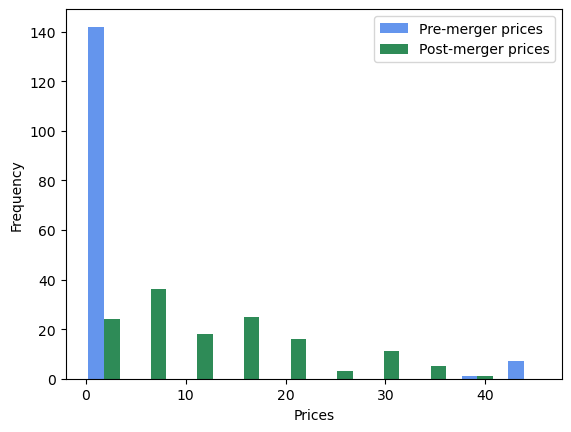

In [26]:
## Solve for optimal prices and assign to DataFrame
p = fsolve(foc, p0, args = (df.copy(), O_merger))
## Save in df to compare
df['price_new2'] = 0.0
df.loc[df['product_id'] != 0, 'price_new2'] = p

print('Median price before merger: %s, Median price after merger: %s' \
      % (df.loc[df['product_id'] != 0, 'price'].median(), \
         df.loc[df['product_id'] != 0, 'price_new2'].median()))
    
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df.loc[df['product_id'] != 0, 'price'])
b_heights, b_bins = np.histogram(df.loc[df['product_id'] != 0, 'price_new2'], \
    bins=a_bins)
width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label = 'Pre-merger prices')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label = 'Post-merger prices')
ax.legend()
plt.xlabel('Prices')
plt.ylabel('Frequency')